Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Что такое Retention?

Это отношение числа вернувшихся в игру пользователей к числу зарегистрировавшихся в ней в определённую дату или за определенный срок.

Пример расчета Retention:

    1) В день X приложение установили 25 человек.
    2) Из 25 человек в день X+1 приложение открыло 9 человек.
    3) Retention (первого дня) = (9/25) * 100% = 36%.

Мною была создана функция retention_per_day, строящая когорты с посчитанным Retention с помощью 4 вводных:

    1) reg - файл, содержащий в себя даты регистраций пользователей.
    2) auth - файл, содержащий в себя даты авторизаций пользователей.
    3) start - дата, с которой ведется сбор вводных данных.
    4) end - дата, до которой ведется сбор вводных данных.

В моем примере был посчитан Retention за неделю: "2019-02-01" - "2019-02-08".

Для создания функции была использована библиотека pandas, а также библиотеки seaborn и matplotlib для визуализации работы функции.

# Подготовка

Перед созданием функции я импортировал библиотеки и файлы с данными.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kobzev-24/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kobzev-24/shared/problem1-auth_data.csv', sep=';')

# Функция:

In [2]:
def retention_per_day(reg, auth, start, end):
#   Делаем мердж двух файлов
    task_1 = auth_data.merge(reg_data, how='left', on='uid') 
    task_1 = task_1.reindex(columns=['uid', 'auth_ts', 'reg_ts'])
    
#   Меняем формат UNIX TIME
    task_1['auth_ts'] = pd.to_datetime(task_1.auth_ts, unit='s')
    task_1['reg_ts'] = pd.to_datetime(task_1.reg_ts, unit='s')

#   Формат времени - день.
    task_1['reg_ts'] = task_1.reg_ts.dt.to_period('D')
    task_1['auth_ts'] = task_1.auth_ts.dt.to_period('D')

#   Считаем Retention
    task_1 = (task_1.groupby(['reg_ts', 'auth_ts'])[['uid']]\
                       .nunique()\
                       .assign(total = lambda x: x.groupby('reg_ts')[['uid']].transform(lambda x: x[0]),
                               retention = lambda x: 100 * x.uid / x.total)\
                       .reset_index()\
                       .round(2)
              )

#   Создание сводной таблицы.
    task_1_pivot = (task_1[['reg_ts', 'auth_ts', 'retention']]\
                             .pivot(columns='auth_ts', index='reg_ts')['retention']
                   )

#   Отбираем данные за необходимый период дней.
    task_1_pivot = task_1_pivot.loc[start:end, start:end]
    
    return task_1_pivot

# Активация функции:

In [3]:
retention_per_day(reg_data, auth_data, "2019-02-01", "2019-02-08")

auth_ts,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08
reg_ts,,,,,,,,
2019-02-01,100.0,2.45,4.08,5.71,5.87,5.38,6.85,5.38
2019-02-02,NaN,100.00,1.79,3.42,4.40,4.23,6.35,5.86
2019-02-03,NaN,NaN,100.00,1.63,2.76,5.04,6.18,7.32
2019-02-04,NaN,NaN,NaN,100.00,2.11,4.71,5.52,5.19
2019-02-05,NaN,NaN,NaN,NaN,100.00,2.76,4.21,4.54
2019-02-06,NaN,NaN,NaN,NaN,NaN,100.00,1.13,3.72
2019-02-07,NaN,NaN,NaN,NaN,NaN,NaN,100.00,1.94
2019-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00


# Визуализация сводной таблицы:

Text(0.5, 1.0, 'Retention per Days')

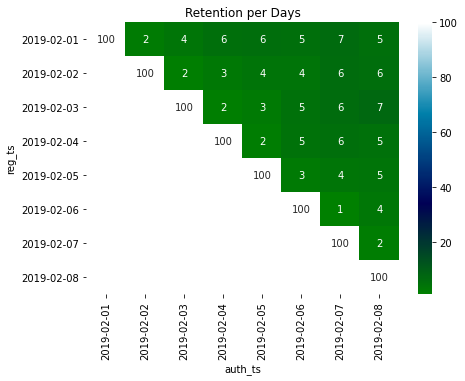

In [4]:
plt.figure(figsize=(7, 5))
sns.heatmap(
    retention_per_day(reg_data, auth_data, "2019-02-01", "2019-02-08"), 
    cmap='ocean', 
    annot=True, 
    fmt='.0f'
).set_title("Retention per Days")

# Разбор функции:

1) Делаем мердж двух файлов с данными по авторизациям и регистрациям. 

Итоговый файл должен сохранить данные об авторизациях, поэтому я использовал Left merge. Для удобства поменял порядок колонок.

Рабочий файл получает название 'task_1'.

In [5]:
task_1 = auth_data.merge(reg_data, how='left', on='uid') 
task_1 = task_1.reindex(columns=['uid', 'auth_ts', 'reg_ts'])

task_1.head(3)

,uid,auth_ts,reg_ts
0,1,911382223,911382223
1,2,932683089,932683089
2,2,932921206,932683089


2) Меняем формат UNIX TIME на дату и время.

In [6]:
task_1['auth_ts'] = pd.to_datetime(task_1.auth_ts, unit='s')
task_1['reg_ts'] = pd.to_datetime(task_1.reg_ts, unit='s')

# Для удобства разбора установил рамки исследуемых данных: "2019-02-01" - "2019-02-08".
task_1 = task_1.query('reg_ts >= "2019-02-01" and auth_ts <= "2019-02-08"')

task_1.head(3)

,uid,auth_ts,reg_ts
3562369,413524,2019-02-01 00:01:11,2019-02-01 00:01:11
3562379,413525,2019-02-01 00:03:32,2019-02-01 00:03:32
3562390,413526,2019-02-01 00:05:53,2019-02-01 00:05:53


3) Устанавливаем верный формат даты в виде дня.

Задание требует от нас посчитать Retention игроков по дням.

In [7]:
task_1['reg_ts'] = task_1.reg_ts.dt.to_period('D')
task_1['auth_ts'] = task_1.auth_ts.dt.to_period('D')

task_1.head(3)

,uid,auth_ts,reg_ts
3562369,413524,2019-02-01,2019-02-01
3562379,413525,2019-02-01,2019-02-01
3562390,413526,2019-02-01,2019-02-01


4) Считаем Retention.

Итак:

    1) Сперва я группирую дни регистарции и авторизации по числу пользователей.
    2) Вывожу уникальных пользователей.
    3) Создал колонку total - в ней будет указано число пользователей, которые прошли регистрацию в определенные дни.
    4) Создал колонку retention с посчитанным Retention.
    5) Для удобства округлил значение Retention до 2 знаков после запятой.

In [8]:
task_1 = (task_1.groupby(['reg_ts', 'auth_ts'])[['uid']]\
                       .nunique()\
                       .assign(total = lambda x: x.groupby('reg_ts')[['uid']].transform(lambda x: x[0]),
                               retention = lambda x: 100 * x.uid / x.total)\
                       .reset_index()\
                       .round(2)
         )

task_1.head(3)

,reg_ts,auth_ts,uid,total,retention
0,2019-02-01,2019-02-01,613,613,100.00
1,2019-02-01,2019-02-02,15,613,2.45
2,2019-02-01,2019-02-03,25,613,4.08


5) Создаем сводную таблицу.

In [9]:
task_1_pivot = (task_1[['reg_ts', 'auth_ts', 'retention']]\
                             .pivot(columns='auth_ts', index='reg_ts')['retention']
               )

task_1_pivot

auth_ts,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07
reg_ts,,,,,,,
2019-02-01,100.0,2.45,4.08,5.71,5.87,5.38,6.85
2019-02-02,NaN,100.00,1.79,3.42,4.40,4.23,6.35
2019-02-03,NaN,NaN,100.00,1.63,2.76,5.04,6.18
2019-02-04,NaN,NaN,NaN,100.00,2.11,4.71,5.52
2019-02-05,NaN,NaN,NaN,NaN,100.00,2.76,4.21
2019-02-06,NaN,NaN,NaN,NaN,NaN,100.00,1.13
2019-02-07,NaN,NaN,NaN,NaN,NaN,NaN,100.00


6) Отбираем данные за необходимый период дней.

task_1_pivot = task_1_pivot.loc[start:end, start:end]